# Sephora Sentiment Prediction Classifer

## Introduction
#### The Sentiment Prediction includes 2 main objectives
1. sentiment prediction
- to explore and train a classfier to predict the sentiment of reviews using NB
- to understand key features contributing to the sentiments 
- to compare NB classfier V.S. BERT

2. sentiment analysis 
- use VADER to understand polarity and subjectivity
- potentially to mine sentiment keywords using EDA

#### the content of this notebook includes the followings
- Baseline model
- Advanced EDA to understand potential hyper tuning
- Naive Bay model Fine Tuning 
- BERT
- explore VADER


## About classfier pipeline


the defination are stored seperately in sentiment_nb.py file, and import into the jupyter notebook for cleaer flow, some functions are listed below:

class classifer
- preprocesser: lowercase, stopword, lemmatizer, remove_plural, customized_stopword
- vectorizer: count, tfidf, word2vec
- naive bayes classfier: preprocessors -> vectorizer -> train -> evaluate

class Visualization
- draw confusion_matrix for different labels
- draw samples of wrongly classfied text to understand why its wrongly labeled
- show top features which contributes to the prediction 

class Validator
- take in munual text input
- predict the label for munual validation

## Data Import 

In [1]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt

from naive_bayes_utils import NaiveBayesClassifier

In [2]:
# set display options for max column width
pd.set_option('display.max_colwidth', 30)

latest_review = pd.read_csv('data/latest_review.csv')
latest_review 

/var/folders/8z/fr1y76rn6js5w526_mc9y1hh0000gn/T/ipykernel_15461/2735324189.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  latest_review = pd.read_csv('data/latest_review.csv')


,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,...,hair_color,product_id,product_name,brand_name,price_usd,primary_category,secondary_category,tertiary_category,true_sentiment,length
0,1796832802,3,0.0,0.714286,7,2,5,2022-12-31,I decided to try this as I...,"Decent, but cheaper produc...",...,red,P420652,Lip Sleeping Mask Intense ...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,neutral,172
1,10255886039,2,0.0,0.500000,2,1,1,2022-12-31,Might as well be putting o...,Where’s the smell??,...,NaN,P420652,Lip Sleeping Mask Intense ...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,negative,160
2,5049431408,5,1.0,1.000000,4,0,4,2022-12-31,Love this lip mask nothing...,Must buy!,...,blonde,P420652,Lip Sleeping Mask Intense ...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,positive,92
3,7052423388,4,1.0,0.333333,3,2,1,2022-12-31,I really enjoy this produc...,Lovely smell,...,blonde,P420652,Lip Sleeping Mask Intense ...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,positive,148
4,23120633832,5,1.0,0.500000,2,1,1,2022-12-31,The best. I have nothing e...,Amazing,...,NaN,P420652,Lip Sleeping Mask Intense ...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,positive,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192222,9109189891,5,1.0,NaN,0,0,0,2022-04-29,I LOVE this stuff! It work...,Great product!,...,NaN,P500101,Hydro Ungrip Makeup Remove...,MILK MAKEUP,32.0,Skincare,Cleansers,Makeup Removers,positive,153
192223,8115925555,5,1.0,NaN,0,0,0,2022-04-29,love this micellar water f...,NaN,...,red,P500101,Hydro Ungrip Makeup Remove...,MILK MAKEUP,32.0,Skincare,Cleansers,Makeup Removers,positive,133
192224,10723607564,5,1.0,NaN,0,0,0,2022-04-29,I loveeeeee Milk!!! Just d...,NaN,...,black,P500101,Hydro Ungrip Makeup Remove...,MILK MAKEUP,32.0,Skincare,Cleansers,Makeup Removers,positive,125
192225,5953458355,5,1.0,NaN,0,0,0,2022-04-29,My new favorite makeup rem...,Works extremely well,...,blonde,P500101,Hydro Ungrip Makeup Remove...,MILK MAKEUP,32.0,Skincare,Cleansers,Makeup Removers,positive,255


In [3]:
# understand what are the columns in the dataset
latest_review.columns

Index(['author_id', 'rating', 'is_recommended', 'helpfulness',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 'submission_time', 'review_text',
       'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color',
       'product_id', 'product_name', 'brand_name', 'price_usd',
       'primary_category', 'secondary_category', 'tertiary_category',
       'true_sentiment', 'length'],
      dtype='object')

In [4]:
# only keep relevent cols to reduce processing time
columns_to_keep = ['rating', 'is_recommended', 'helpfulness','submission_time', 
                   'review_text','review_title', 'length',
                   'product_name', 'brand_name', 'price_usd',
                   'primary_category', 'secondary_category', 'tertiary_category',
                   'true_sentiment', ]
latest_review = latest_review[columns_to_keep]

## Model Training Baseline

After simple EDA (refer to main file), a classfier pipeline using Naive Bay model is constructed. The baseline model is using clean text without further engineered features. 

The parameters used for the baseline model as below:
- target variables: true sentiments (<=2: negative, =3: neutral, >=4: positive)
- input data: all reviews
- features: only 'review_text'
- preprocessor: lowercase
- vectorizer: count


In [5]:
# train baseline model with latest_review for the baseline model
preprocessors = ['lowercase']
nb_classifier = NaiveBayesClassifier(data=latest_review, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = nb_classifier.train(vectorizer_type='count', use_additional_features=False)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [6]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.87263
Test Accuracy: 0.86337


In [7]:
# set column labels
labels = sorted(nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.87263
precision: 0.88487
recall: 0.87263
f1: 0.87797
f2: 0.87505

Confusion Matrix:


,Predicted negative,Predicted neutral,Predicted positive
True negative,7653,1299,1535
True neutral,1562,4470,2766
True positive,2655,4873,88523


In [8]:
# get train evaluation for test set
print("\nTest:")
nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.86337
precision: 0.87448
recall: 0.86337
f1: 0.86839
f2: 0.86556

Confusion Matrix:


,Predicted negative,Predicted neutral,Predicted positive
True negative,4646,1017,1148
True neutral,1263,2468,2059
True positive,1741,3278,59271


In [9]:
results_list = []

new_entry = {
    'Name': 'Baseline Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, negative, neutral',
    'remarks': 'baseline model'
}

results_list.append(new_entry)
results_list


[{'Name': 'Baseline Model',
  'Train Accuracy': 0.8726330027051398,
  'Train Precision': 0.8848691353143678,
  'Train Recall': 0.8726330027051398,
  'Train F1': 0.8779655023510915,
  'Train F2': 0.8750530815889245,
  'Train Confusion Matrix': [[7653, 1299, 1535],
   [1562, 4470, 2766],
   [2655, 4873, 88523]],
  'Test Accuracy': 0.8633650232146806,
  'Test Precision': 0.8744765243432968,
  'Test Recall': 0.8633650232146806,
  'Test F1': 0.8683897893617993,
  'Test F2': 0.8655646758307657,
  'Test Confusion Matrix': [[4646, 1017, 1148],
   [1263, 2468, 2059],
   [1741, 3278, 59271]],
  'Preprocesser': ['lowercase'],
  'Vectorizer': 'count',
  'Classifier': 'Naive Bayes',
  'Feature': 'review_text',
  'Target': 'positive, negative, neutral',
  'remarks': 'baseline model'}]

In [10]:
# sample incorrect prediction 
from naive_bayes_utils import NaiveBayesVisualization
visualizer = NaiveBayesVisualization(nb_classifier)
text = visualizer.display_incorrect_samples()
text

Review: Love this lip mask nothing else will do Aquaphor and Vaseline just aren’t as moisturizing as this mask is I recommend it to everyone I know￼
Review Procrssed: love this lip mask nothing else will do aquaphor and vaseline just aren’t as moisturizing as this mask is i recommend it to everyone i know￼
Actual Sentiment: positive
Predicted Sentiment: negative

Review: I had chapped lips suddenly (normally not a problem for me) and after several days of lip balm/chapstick, they only started healing once I started using this. I had a sample from a reward or birthday gift. I will definitely keep it on hand for the future.
Review Procrssed: i had chapped lips suddenly (normally not a problem for me) and after several days of lip balm/chapstick, they only started healing once i started using this. i had a sample from a reward or birthday gift. i will definitely keep it on hand for the future.
Actual Sentiment: positive
Predicted Sentiment: negative

Review: I put off getting this for too

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['prediction'] = self.validator.predict_batch(self.data['reviews_processed'].tolist())


it is observed from both confusion matrix and sample data:
- the classfier does not prefrom well with neutral labeled data. With human observation, many of 'netural' data are not netural but contains sentiments, such data might create a nosie to the whole dataset. 
- misclassification among positive and negtive to be imporved  

## Advanced EDA

In [11]:
latest_review.columns

Index(['rating', 'is_recommended', 'helpfulness', 'submission_time',
       'review_text', 'review_title', 'length', 'product_name', 'brand_name',
       'price_usd', 'primary_category', 'secondary_category',
       'tertiary_category', 'true_sentiment', 'reviews_processed',
       'prediction'],
      dtype='object')

### deal with duplicated reviews

In [12]:
# Adjust pandas display options
pd.set_option('display.max_colwidth', None)

In [13]:
# check % of duplicated rows
total_rows = len(latest_review)
unique_reviews = latest_review['review_text'].nunique()
duplicates = total_rows - unique_reviews
percentage_duplicates = (duplicates / total_rows) * 100

print(f"Total number of rows: {total_rows}")
print(f"Number of unique reviews: {unique_reviews}")
print(f"Number of duplicate reviews: {duplicates}")
print(f"Percentage of duplicate reviews: {percentage_duplicates:.2f}%")


Total number of rows: 192227
Number of unique reviews: 172007
Number of duplicate reviews: 20220
Percentage of duplicate reviews: 10.52%


In [14]:
# sample top 10 helpfulness duplicated reviews
duplicate_reviews = latest_review[latest_review.duplicated(subset='review_text', keep=False)].sort_values('review_text')
selected_columns = ['rating', 'submission_time', 'review_text', 'review_title', 'product_name', 'brand_name', 'price_usd']
duplicate_reviews.sort_values(by=['helpfulness', 'review_text'], ascending=False)[selected_columns].head(10)


,rating,submission_time,review_text,review_title,product_name,brand_name,price_usd
4665,5,2022-12-27,♡AMAZING!♡I love this product so muchh because it really helps my skin that is full of pimples.This is week 2 of using this product.,LOVE IT! I WILL TOTALLY BUY AGAIN,Mini Superfood Antioxidant Cleanser,Youth To The People,14.00
3814,5,2022-12-27,♡AMAZING!♡I love this product so muchh because it really helps my skin that is full of pimples.This is week 2 of using this product.,LOVE IT! I WILL TOTALLY BUY AGAIN,Superfood Antioxidant Cleanser,Youth To The People,39.00
19860,5,2022-07-19,•consistency reminds me kind of like a makeup primer? (which I like)•rubs in completely clear & doesn’t leave any shine•there’s a scent but not overpowering •i’d recommend a moisturizer before this sunscreen,I dig it,Unseen Sunscreen SPF 40 PA+++,Supergoop!,48.00
20395,5,2022-07-19,•consistency reminds me kind of like a makeup primer? (which I like)•rubs in completely clear & doesn’t leave any shine•there’s a scent but not overpowering •i’d recommend a moisturizer before this sunscreen,I dig it,Mini Unseen Sunscreen SPF 40 PA+++,Supergoop!,22.00
159647,5,2022-07-30,İ love it and makes my dull skin refreshed and bright.,NaN,Fulvic Acid Brightening Cleanser,The INKEY List,11.99
159747,5,2022-07-30,İ love it and makes my dull skin refreshed and bright.,NaN,Mini Fulvic Acid Brightening Cleanser,The INKEY List,5.99
25869,3,2022-01-01,you NEED to wash it off with a different cleanser!!! this is more of a make up remover greasy balm.,"If you buy this, double cleanse",Oat Cleansing Balm,The INKEY List,11.99
26722,3,2022-01-01,you NEED to wash it off with a different cleanser!!! this is more of a make up remover greasy balm.,"If you buy this, double cleanse",Mini Oat Cleansing Balm,The INKEY List,5.99
25831,1,2022-01-08,"worst product ever, im SO disappointed i strayed from my OG Clinique take the day off. For one, this doesn’t work AT ALL - it doesn’t take makeup off at all. The worst though, is that the product completely seperated. I went to use it, and a bit of cleanser came out and then the rest was just gross liquid. throwing this out ASAP, so upset.",DO NOT BUY,Oat Cleansing Balm,The INKEY List,11.99
26684,1,2022-01-08,"worst product ever, im SO disappointed i strayed from my OG Clinique take the day off. For one, this doesn’t work AT ALL - it doesn’t take makeup off at all. The worst though, is that the product completely seperated. I went to use it, and a bit of cleanser came out and then the rest was just gross liquid. throwing this out ASAP, so upset.",DO NOT BUY,Mini Oat Cleansing Balm,The INKEY List,5.99


after checking the duplicated reviews, the duplicated reviews are made by the same customer, on the same day, for the same product but in different size. It can be considered as noise in the trainning data as it populates 10% of data, such data should be removed to keep only one row with the normal size. 

In [15]:
# drop duplicates and store into new df
df = latest_review.drop_duplicates(subset='review_text', keep='first')

### understand the text through word cloud

#### no stopwords

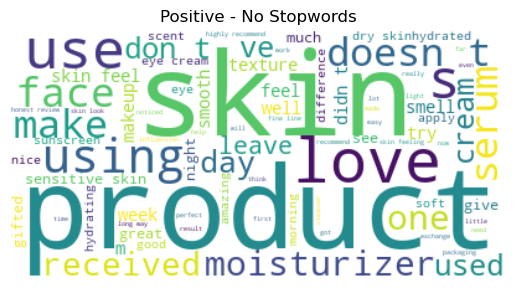

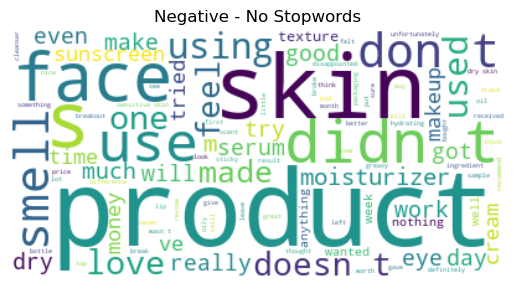

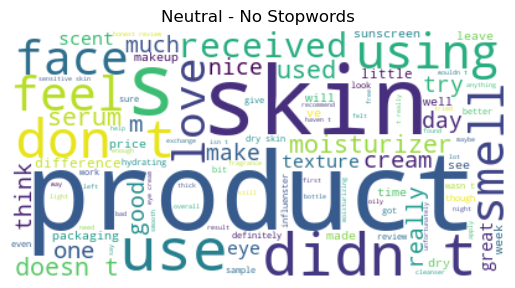

In [16]:
# draw some wordcloud with no stopwords
sentiments = ['positive', 'negative', 'neutral']
for sentiment in sentiments:
    sentiment_df = df[df['true_sentiment'] == sentiment]
    text = ' '.join(sentiment_df['review_text']).lower()
    wc1 = WordCloud(background_color="white", max_words=100).generate(text)
    plt.imshow(wc1, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{sentiment.capitalize()} - No Stopwords")
    plt.show()


It has been observed that this review dataset contains a high frequency of product-related terms, such as 'skin', 'product', and 'face', across all sentiment categories. These words don't significantly influence predictions and should be classified as stopwords. 

Many reviews directly address the product; therefore, such information should be filtered out. While certain products might display predominantly positive or negative sentiments, including this data could introduce predefined biases or stereotypes about the product. Consequently, this could compromise the effectiveness of our sentiment classifier.

#### Only with Custom Stopwords

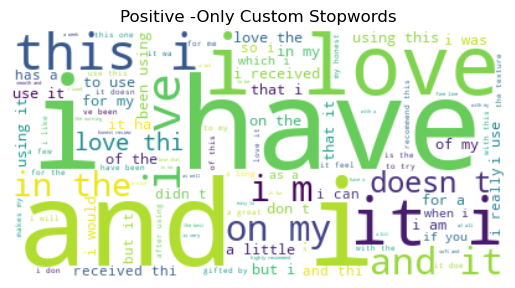

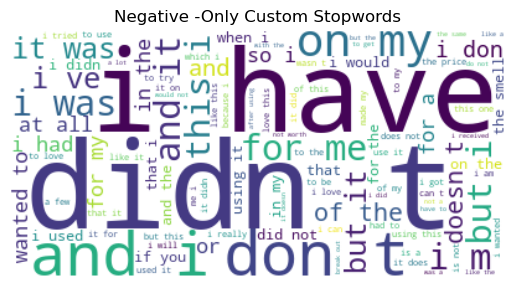

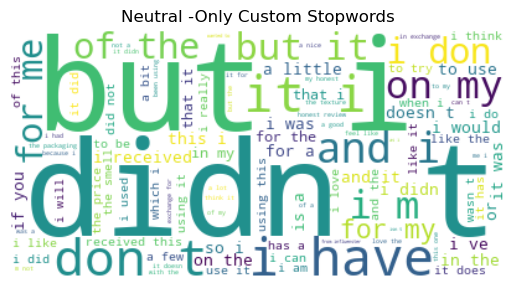

In [17]:
# draw wordcloud with custom stopword
custom_stopwords = {'skin','product','face','cream','serum','moisturizer','makeup','eye','sunscreen','eyes','products','s'}
sentiments = ['positive', 'negative', 'neutral']
for sentiment in sentiments:
    sentiment_df = df[df['true_sentiment'] == sentiment]
    text = ' '.join(sentiment_df['review_text']).lower()
    wc2 = WordCloud(background_color="white", max_words=100, stopwords=custom_stopwords).generate(text)
    plt.imshow(wc2, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{sentiment.capitalize()} -Only Custom Stopwords")
    plt.show()

After removing the custom stopwords from the Sephora dataset, the word cloud is dominated by typical stopwords. These don't offer insights into the three distinct sentiment categories. Therefore, additional common English stopwords should be included.

#### custom & common english stopword

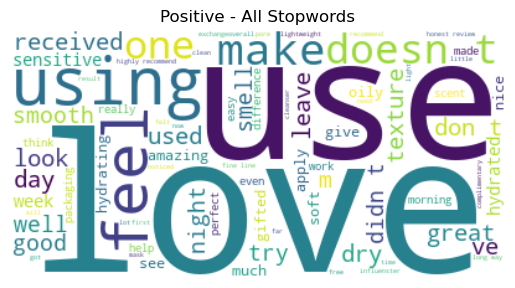

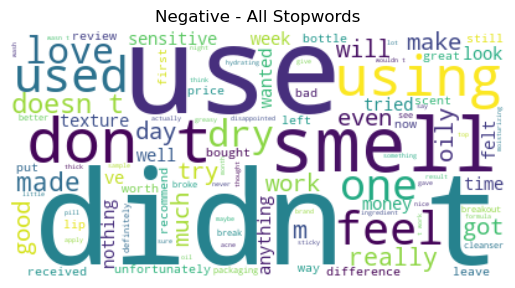

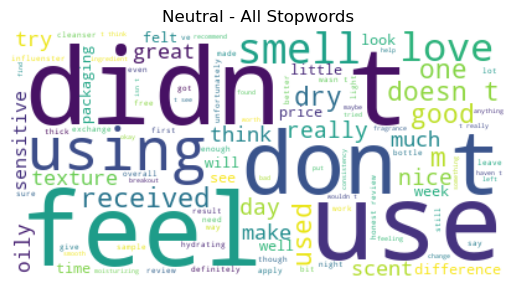

In [18]:
all_stopwords = STOPWORDS.union(custom_stopwords)
sentiments = ['positive', 'negative', 'neutral']
for sentiment in sentiments:
    sentiment_df = df[df['true_sentiment'] == sentiment]
    text = ' '.join(sentiment_df['review_text']).lower()
    wc3 = WordCloud(background_color="white", max_words=100, stopwords=all_stopwords).generate(text)
    plt.imshow(wc3, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{sentiment.capitalize()} - All Stopwords")
    plt.show()

With the integration of these combined stopwords, the word cloud for the three sentiments displayed a noticeable distinction. These stopwords will be referenced later in the notebook and within the Python definition

### understanding target variables/lebal: rating & is_recommended

can is_recommended be used as target variables? 

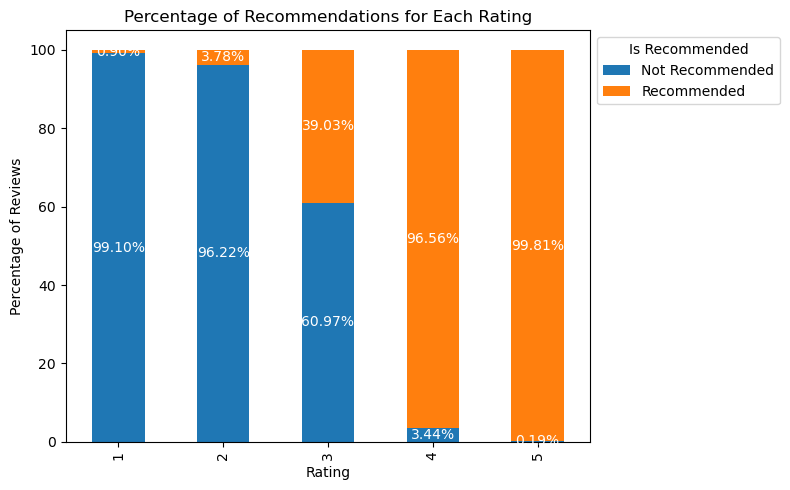

In [19]:
# understand % of is_recommended for different ratings

pivot_data = df.groupby(['rating', 'is_recommended']).size().unstack().fillna(0)
pivot_data_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Plotting
ax = pivot_data_percentage.plot(kind='bar', stacked=True, figsize=(8, 5))
ax.set_title('Percentage of Recommendations for Each Rating')
ax.set_xlabel('Rating')
ax.set_ylabel('Percentage of Reviews')
ax.legend(title="Is Recommended", labels=["Not Recommended", "Recommended"], loc="upper left", bbox_to_anchor=(1, 1))

# Annotate with the percentage values
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x+width/2, y+height/2, f"{height:.2f}%", ha='center', va='center', color='white')

plt.tight_layout()
plt.show()


logically, user give higher ratings would more likely to recommend certain products 
- why some users recommend a product even if they give it a rating of 1? 
- why some don't recommend a product even if they give it a rating of 5?
- is is_recommended a valuable column to use? 

To achieve objectives above:
- Sample top 10 helpful(helpfulness) review where a user gave a rating of 1 but recommended the product.
- Sample top 10 helpful(helpfulness) review where a user gave a rating of 5 but didn't recommend the product.
- Generate word cloud for each type

In [20]:
# sample reviews with rating 1 but recommended
recommended_with_1 = df[(df['rating'] == 1) & (df['is_recommended'] == 1)]

# Display the top 10 reviews based on helpfulness
top_10_reviews = recommended_with_1.nlargest(10, 'helpfulness')
display(top_10_reviews[['review_text', 'review_title', 'product_name', 'brand_name', 'price_usd']])

,review_text,review_title,product_name,brand_name,price_usd
38428,"Love the original, hate the refill. Purchased the refill to save some money and plastic. I followed the instructions to replace the refill and The pump no longer works and I can’t unscrew the refill to get the product out by hand. I’ve essentially wasted the $42 and my local Sephora doesn’t carry this product so I can’t exchange it. I’m just going to see if I can break the container open to salvage some of my purchase. Don’t buy the refill.",NaN,Barrier+ Triple Lipid-Peptide Face Cream,Skinfix,54.00
42566,"It feels very cooling when first applied, but that’s it. It doesnt work, it doesn’t depuff, it doesn’t anything. I’ve been using it for months and I haven’t seen any change at all. It does absorb easily and the gel like texture makes it easy to apply in specific areas, but it doesn’t do anything.",Doesn't work,Caffeine 5% + EGCG Depuffing Eye Serum,The Ordinary,8.90
54137,I didn’t use this product because it did not have a safety seal when you opened it. It was just there. I prefer not to put product around my eyes.,I didn't use it,Advanced Night Repair Eye Gel-Cream,Estée Lauder,72.00
58368,"I do not like the knew packaging. A lot more formula comes out, I feel like I use more product now then before before and the bottle keeps opening all together I constantly have to be Putting it back together",I miss the old formula,C-Firma Fresh Vitamin-C Day Serum,Drunk Elephant,78.00
62118,The product is perfect but imagine purchasing the item and have a complete reaction due to the product being expired!! Thank you Sephora for not pulling your expired items off the shelf. Expectation date May 2022 and it’s almost 2023. I returned the product for an exchange but all of them were expired!Speechless!!,Check The Expiration Date,CC+ Cream Oil-Free Matte with SPF 40,IT Cosmetics,44.00
87609,"The old formula was 10 stars. I’ve been loyal to it for probably 7 years, and I’m a product junkie. Nothing beat the old formula.It’s probably not 1 star now, but compared to the old formula which was 10 stars, the new formula is 1 by comparison. The old formula gave a squeaky clean feeling, got rid of blackheads and other skin issues.New formula isn’t just thicker, it doesn’t give the squeaky clean feeling that the old formula had, it doesn’t clear blackheads or dry skin acne.I have dry skin, with acne and the old formula fixed that. The new formula just isn’t the same at all.","New formula isn’t the same, completely different",Purifying Gentle Foaming Cleanser with Salicylic Acid,Clarins,30.00
88070,"Love this cream, BUT this is my second time getting one and the pump doesn’t work!!! So frustrating. Expensive cream that works magic, but the pump will not start. I tossed receipt out because I know I love the cream but what a waste.",NaN,Triple Active Retinol Gentle Overnight Renewal Cream,Dr. Brandt Skincare,75.00
102364,"Unfortunately this was extremely harsh on my sensitive skin. It completely broke my skin out-on & around all areas applied. I was given this to sample by BuzzAgent & I’m thankful for the opportunity to try this product. I can understand more what my skin can & cannot tolerate. Just because it didn’t work for me, doesn’t mean it won’t work for you. Kiehl’s has amazing products. You just have to find the right serum & face products for your skin type.",NaN,Clearly Corrective Dark Spot Correcting Serum,Kiehl's Since 1851,65.00
121316,Odd reaction to this after the first use. Don’t usually have sensitivity to any products.,Unusual reaction,Sugar Recovery Lip Mask Advanced Therapy,fresh,28.00
129421,Really didn’t like this product. The smell isn’t my favorite and the texture is gritty felt like an exfoliant and didn’t do much for my skin,NaN,Vitamin C Brightening Cream,The INKEY List,10.99


In [21]:
# sample reviews with rating 5 but not recommended
not_recommended_with_5 = df[(df['rating'] == 5) & (df['is_recommended'] == 0)]

# Display the top 10 reviews based on helpfulness
top_10_reviews_not_recommended = not_recommended_with_5.nlargest(10, 'helpfulness')
display(top_10_reviews_not_recommended[['review_text', 'review_title', 'product_name', 'brand_name', 'price_usd']])


,review_text,review_title,product_name,brand_name,price_usd
1535,"Love this cleanser, use it every day. Very gentle on dry skin. Doesn’t take off my makeup super well so I use it as the second part of a double cleanse if I wear makeup.",NaN,Soy Hydrating Gentle Face Cleanser,fresh,39.0
1556,Soft and nice. Smells almost neutral. Does not dry out my skin.,NaN,Soy Hydrating Gentle Face Cleanser,fresh,39.0
4109,"I have very sensitive, combination skin. This cleanser is the only one I’ve been able to find that has cleared my skin after one use, and keeps my skin under control all around. It’s gentle, but really deeply cleanses without over stripping it. I keep coming back to it time and time again.",GO TO,Superfood Antioxidant Cleanser,Youth To The People,39.0
7637,Loved it deff worth the money for the full size. I don’t use it often but when my skin just need a gentle scrub this is my go to. It feels so smooth & clean after.,Loved it,Mini Daily Microfoliant Exfoliator,Dermalogica,18.0
14584,Best moisturizer for my combination skin. I’ve been using for a little over a year now and my skin has changed drastically,NaN,The Water Cream Oil-Free Pore Minimizing Moisturizer,Tatcha,70.0
14990,It works amazing for sensitive yet acne prone skin,A must have !,Hyaluronic Acid 2% + B5 Hydrating Serum,The Ordinary,15.7
15149,Excelent product! Excelent price and size!Recommended 100%,NaN,Hyaluronic Acid 2% + B5 Hydrating Serum,The Ordinary,15.7
17955,I’m not sure that in my 32 years If living that I have ever seen results from anything that have been this fast AND amazing. My pores were smaller evened after1 use and they continued to get smaller. I also have rosacea which has improved almost to the point where it is gone. I use it 2xs a day and it’s really my holy grail. So glad that I bought the mini on a whim at the checkout!,RESULTS,"Beauty Elixir Prep, Set, Glow Face Mist",Caudalie,49.0
19801,"I wear this everyday and it never breaks me out. I have very sensitive, acne-prone skin and I never have any issues. I use it as a makeup primer too. This product is a daily must have!!",Must have!,Unseen Sunscreen SPF 40 PA+++,Supergoop!,48.0
38387,"Barrier Booster Orange Ferment Essence is lovely!! Love how it glides on and how well it absorbs into my skin! This has really helped with my uneven skintone and has kept my face super hydrated! Living in a city where our pollen count is extremely high, I love knowing I’m wearing this and it’s protecting my skin! My face looks great and I feel a few years younger! Gifted by Barrier, thank you so much for giving me the opportunity to try!!",Love it!!!,Barrier+ Triple Lipid-Peptide Face Cream,Skinfix,54.0


create word cloud to understand high frequency terms

In [22]:
# Define a function to draw the word clouds
def get_word_cloud_text(df):
    return " ".join(review for review in df['review_text'])

def draw_word_cloud(text, ax, title):
    wordcloud = WordCloud(background_color="white", max_words=100, stopwords=all_stopwords).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(title)

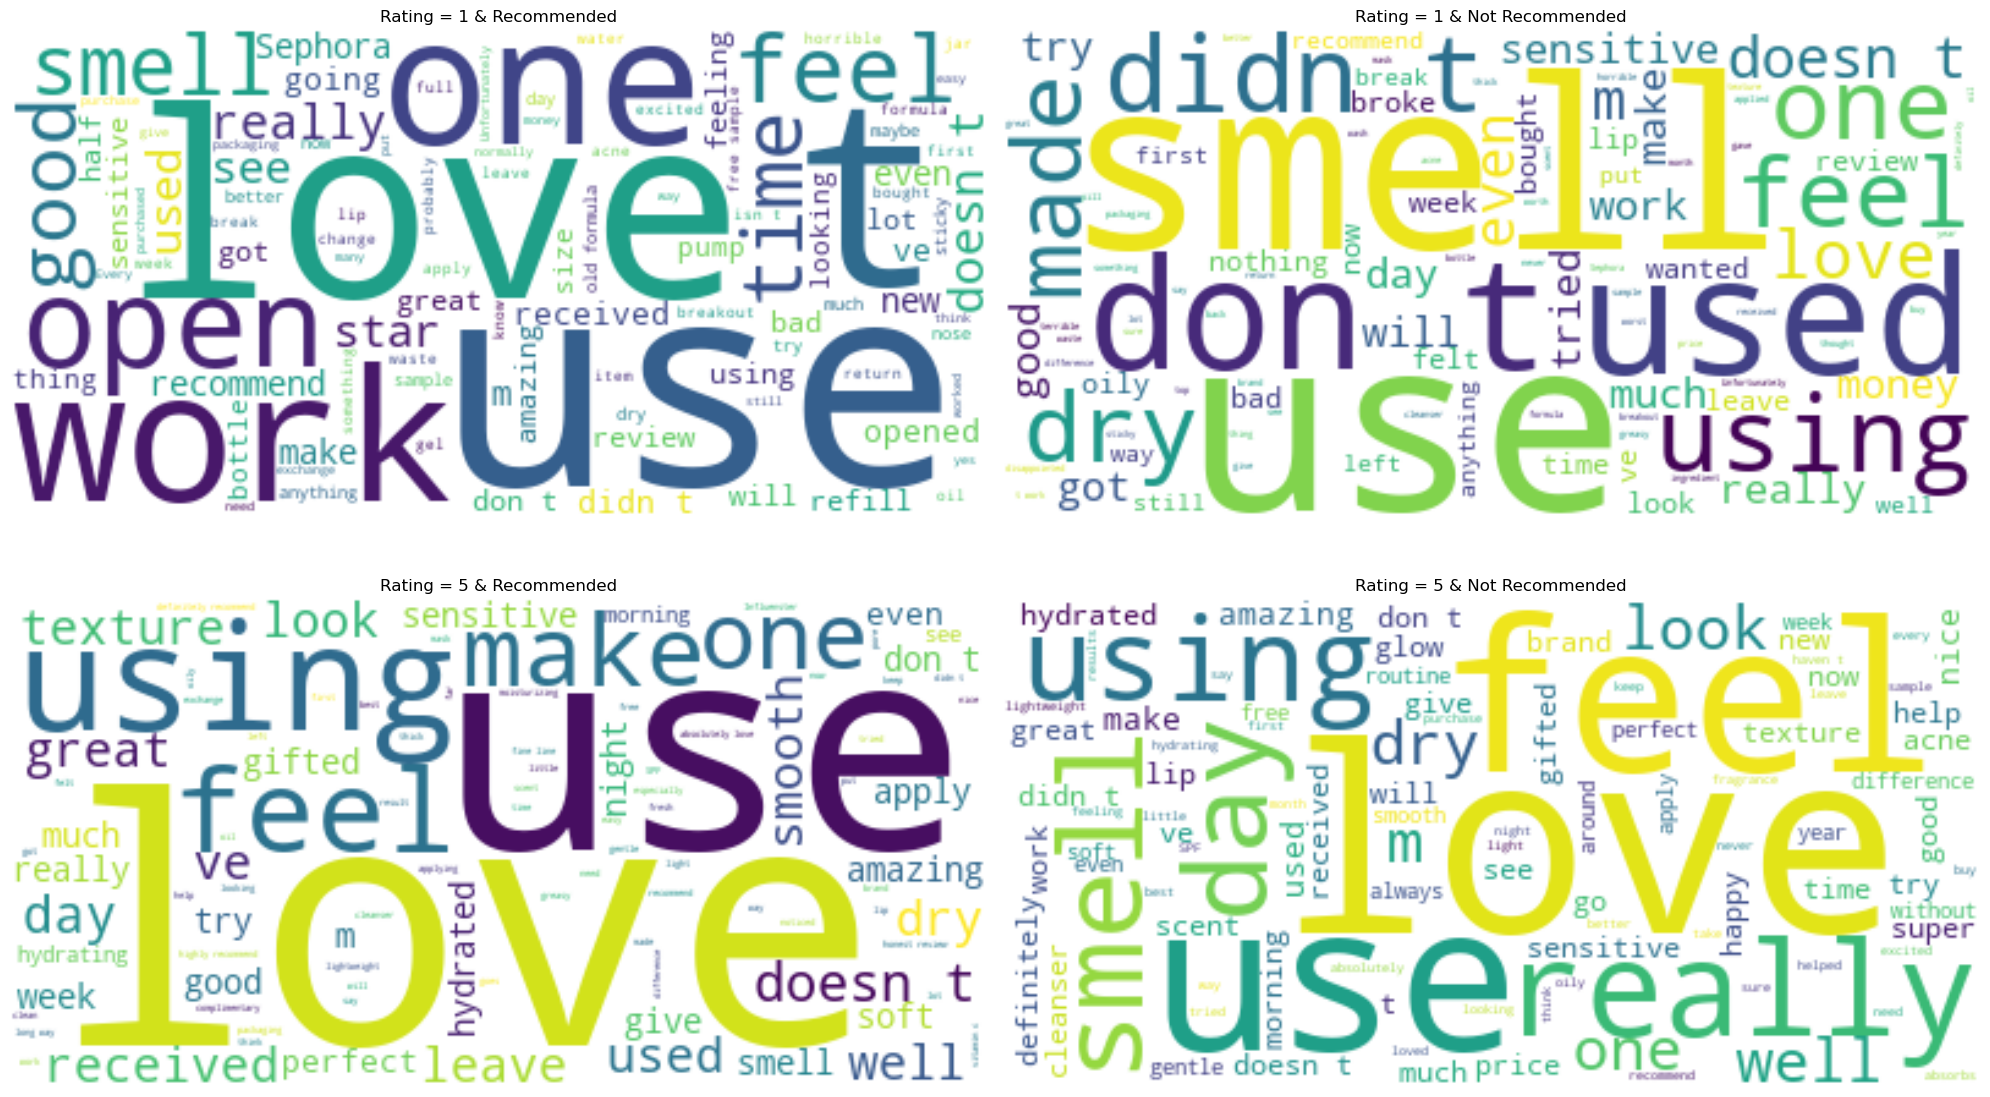

In [23]:
# get dataframe
recommended_with_5 = df[(df['rating'] == 5) & (df['is_recommended'] == 1)]
not_recommended_with_1 = df[(df['rating'] == 1) & (df['is_recommended'] == 0)]

# draw word cloud
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

draw_word_cloud(get_word_cloud_text(recommended_with_1), axs[0, 0], "Rating = 1 & Recommended")
draw_word_cloud(get_word_cloud_text(not_recommended_with_1), axs[0, 1], "Rating = 1 & Not Recommended")
draw_word_cloud(get_word_cloud_text(recommended_with_5), axs[1, 0], "Rating = 5 & Recommended")
draw_word_cloud(get_word_cloud_text(not_recommended_with_5), axs[1, 1], "Rating = 5 & Not Recommended")

plt.tight_layout()
plt.show()

looking at the sample reviews and word cloud above: 
- rating = 1 but recommended usually has no issue with the product itself, but either services, condition of the product etc. this group of reviews should be flagged out and feedback to the relevent stakeholders. 
- rating = 5 but not recommended generally does not show bad emotions/sentiments about the products and related services, potentially a default value = 0 when people doesnt leave an input, or put wrongly. 
- is_recommended is not a good feature to used as target variables, the text sample  since the text sample is primarily based on ratings. 

### understanding target variables/lebal: rating = 3

zoom onto reviews with ratings 3
- it observed that half of 3 review recommend, and the half does not
- current classfier failed to predict netural labels well
- understand the true sentiment
- is such data noise to the dataset?

To achieve above:
- some sample data
- wordcloud

In [24]:
# Filtering out reviews with ratings of 3
reviews_with_3 = df[df['rating'] == 3]

# Fetching top 10 samples for both categories
recommended_samples = reviews_with_3[reviews_with_3['is_recommended'] == 1].sample(10)
not_recommended_samples = reviews_with_3[reviews_with_3['is_recommended'] == 0].sample(10)


In [25]:
# Display the samples
pd.set_option('display.max_colwidth', None)

print("Top 10 Sample Reviews with Rating of 3 that are Recommended:")
display(recommended_samples[['review_text', 'is_recommended', 'true_sentiment']])

print("\nTop 10 Sample Reviews with Rating of 3 that are Not Recommended:")
display(not_recommended_samples[['review_text', 'is_recommended', 'true_sentiment']])

Top 10 Sample Reviews with Rating of 3 that are Recommended:


,review_text,is_recommended,true_sentiment
150231,"I felt that this product was good but not great. It smelled nice but didn’t really clean the way I would hope for. If you use it, I highly suggest the foaming cleanser to pair.",1.0,neutral
166092,"I received this product as part of a free sample program and I have mixed feeling about it. First I’ll start by saying that the coconut scent is AMAZING!!!!! and the size of the bar is just perfect. I normally brake out when using new skin products, within the first 3 days of use, but with the Cocoa Cleans’r Soothing All-Over Cleansing Bar that didn’t happen. One thing that I didn’t really like is that the bar is a little drying for the skin. I have oily skin, and I found it to be too drying, making my skin produce more oil than normal.I like the cleansing bar, but I don’t love it.",1.0,neutral
82915,I received this product for free from Influenster in return for my honest review.This product does what it’s supposed to do! I’ve been applying this product for 3 weeks now. I apply to my shiny areas. Nose and forehead. I have noticed that my nose isn’t as shiny and greasy as before. The con on this product is if you apply too much or don’t rub in long enough you’ll have white flakes that look like glue all over. Very embarrassing. I also don’t think it applies well with moisturizer.,1.0,neutral
32921,"I received this product for free from butterly in exchange of my honest review.This product is so good and feels so light in my skin. Had to mix two ingredients together before applying. Skin felt more softer, however did not see much change into my pores",1.0,neutral
156119,"I opened the package and there was only 1 eye patch inside! Otherwise, I love the texture of these eye patches.",1.0,neutral
24865,"I’m ambivalent... I’ve used it a couple of days now. I had dry skin, mostly my forehead. It helps moisturize a lot, my skin look very good and glowy BUT, I have a shiny face (lol) and sticky texture, not THAT bad, but when I washed my face I’m like ’’ahhhh it feels so good, I removed this layer’’. Don’t know if it’s clear haha",1.0,neutral
80895,"I have very sensitive skin and my skin looked a bit red anytime I used it. I only used it 1x week and didn’t really notice any significant change except mild irritation, but BHAs and AHAs usually irritate my skin. I might use it again to see/may try it on other parts of my body.",1.0,neutral
148915,"I have tried a lot of physical exfoliants and this one was a lot rougher than others. While my face felt clean after use, it also made my skin feel really dry. As someone with dry skin to begin with, I would not use this on a daily basis. I don’t think it’s suited for dry/sensitive skin but would work for normal or oily skin.",1.0,neutral
65810,"the mini size was small, but i didn’t really expect it to be THAT small. if you want to try it, get the full size. i’ve used it a few times, felt kinda oily to me",1.0,neutral
135168,Amazing product but the package peels so badly and it gets on everything.,1.0,neutral



Top 10 Sample Reviews with Rating of 3 that are Not Recommended:


,review_text,is_recommended,true_sentiment
122739,"I loved the idea of a vitamin C sunscreen, but this leaves a lot to be desired. I have sensitive combo skin prone to hyperpigmentation with increasing winter dryness. I used 2 pumps to cover my cheeks, where I have the most sun damage, and applied another sunblock over the whole face, and on days I have meetings, some makeup over that.I used it for over a month, and didn’t notice any lasting difference in my skin. It did look a little glossy when I applied it on my face in the mornings and it didn’t irritate my sensitive skin, so I feel neutral about it. The occasional day I skipped this, I didn’t miss it or feel like my face was dry or anything. It didn’t seem to interfere with any makeup application (liquid foundation, a bit of powder on places that need it) for me. TEXTURE was weird, and at first, it was mostly a runny yellowish oil with some foamy/creamy looking streaks, and now it’s mostly the creamy looking stuff and just a little oil. I shook the bottle before every application, and it never looked like the product photos. PACKAGING HAS MAJOR ISSUES. I generally like pump bottles, but this is crap and a waste of plastic to create a fat ball around an internal container of 1 oz. of product. The little plastic pump button gets stuck every time so I have to pull it up with my fingers before I can squeeze out another pump of product. Also, there’s obviously a fair amount of product left but the pump sputters and doesn’t pull out much product now, so instead of 2 pumps, I’m pumping 5-10 times, each time spitting out little spattery bits. The 1 oz. bottle lasted about 6 weeks of near daily use of 2 pumps of product, the last week dispensing 1 pump’s worth after repeated tries until I got frustrated and moved on. I have lots of 1 oz. bottles of different serums. I know what 1 oz. looks like and how long it should last. This container is making lots of waste of product and plastic. For $46, I wish the product looked like the photos and had a better pump.",0.0,neutral
139664,It’s a decent toner nothing revolutionary to me. The sample I was sent was too small to really see a difference but otherwise it’s okay.,0.0,neutral
44218,I don’t like this under my foundation at all. It doesn’t seem to be a good primer. It’s definitely good mixed with tinted moisturizer I guess or worn alone. I was doing some research and found this doesn’t actually protect your skin from the rays and all that. Prob not buying again.,0.0,neutral
107103,"Heavy, moisturizing eye cream. Didn’t really sink in so I could only use it at night. Love that it has retinol so probably is more effective with long term use, otherwise it didn’t wow me.",0.0,neutral
145514,"I love drunk elephant and use a few products from them. I use the prontini moisturizer, vitamin c serum, glycolic serum, the baby facial and the bronzer drops and love them all. This is a miss for me. When I use eye cream I put it on under my eye and on my eyelid. I like that it’s thick and feels moisturizing. The issue I have with this is that it some home gets I my eye and stings my actual eyes. I’ve never had this issue with any other eye creams, even ones with retinol. I tried to just put it underneath my and it still got into my eyes and they stung. I really don’t recommend this product.",0.0,neutral
43861,"I wanted to like this for the price point and clinical ingredients, but it pills with the Ordinary Vitamin C and doesn’t absorb immediately. Eventually it will absorb, but my dry skin still feels dry afterwards. I don’t think there is enough moisturizer for me in this formula.",0.0,neutral
83960,"I thought it works for cleaning mascara but only works for regular make up and nothing on the eyes, if you need to clean only make up around your face then this product is fine for you otherwise I wouldn’t recommend this product.",0.0,neutral
98457,I am a little up in the air about this product. I try using it every day (whether just in the morning or 

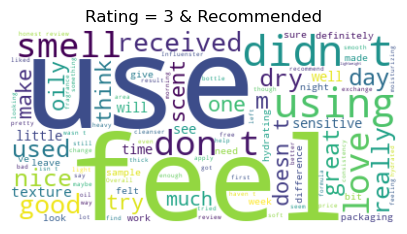

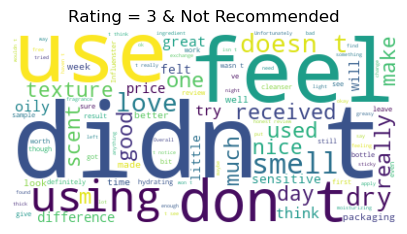

In [26]:
def generate_word_cloud(df, title):
    text = " ".join(review for review in df['review_text'])
    wordcloud = WordCloud(background_color="white", max_words=100,stopwords=all_stopwords).generate(text)
    plt.figure(figsize=(5, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate word clouds
generate_word_cloud(reviews_with_3[reviews_with_3['is_recommended'] == 1], "Rating = 3 & Recommended")
generate_word_cloud(reviews_with_3[reviews_with_3['is_recommended'] == 0], "Rating = 3 & Not Recommended")


review with rating of 3, seems to have both negtive and positive feedbacks. Thus such reviews could be recognozied as noise to be excluded

In [27]:
# create a new dataframe df_no_3 to store only positive and negative feedbacks
df_no_3 = df[df['rating'] != 3]
pd.set_option('display.max_colwidth', 50)
df_no_3


,rating,is_recommended,helpfulness,submission_time,review_text,review_title,length,product_name,brand_name,price_usd,primary_category,secondary_category,tertiary_category,true_sentiment,reviews_processed,prediction
1,2,0.0,0.500000,2022-12-31,Might as well be putting on Vaseline because I...,Where’s the smell??,160,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,negative,might as well be putting on vaseline because i...,negative
2,5,1.0,1.000000,2022-12-31,Love this lip mask nothing else will do Aquaph...,Must buy!,92,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,positive,love this lip mask nothing else will do aquaph...,negative
3,4,1.0,0.333333,2022-12-31,I really enjoy this product! Amazing smell and...,Lovely smell,148,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,positive,i really enjoy this product! amazing smell and...,positive
4,5,1.0,0.500000,2022-12-31,The best. I have nothing else to really say ot...,Amazing,36,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,positive,the best. i have nothing else to really say ot...,positive
5,5,1.0,NaN,2022-12-31,I had chapped lips suddenly (normally not a pr...,Lip Saver!,153,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,positive,i had chapped lips suddenly (normally not a pr...,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192222,5,1.0,NaN,2022-04-29,I LOVE this stuff! It works amazingly well at ...,Great product!,153,Hydro Ungrip Makeup Remover + Cleansing Water,MILK MAKEUP,32.0,Skincare,Cleansers,Makeup Removers,positive,i love this stuff! it works amazingly well at ...,positive
192223,5,1.0,NaN,2022-04-29,love this micellar water from Milk! it removes...,NaN,133,Hydro Ungrip Makeup Remover + Cleansing Water,MILK MAKEUP,32.0,Skincare,Cleansers,Makeup Removers,positive,love this micellar water from milk! it removes...,positive
192224,5,1.0,NaN,2022-04-29,I loveeeeee Milk!!! Just discovered this brand...,NaN,125,Hydro Ungrip Makeup Remover + Cleansing Water,MILK MAKEUP,32.0,Skincare,Cleansers,Makeup Removers,positive,i loveeeeee milk!!! just discovered this brand...,positive
192225,5,1.0,NaN,2022-04-29,"My new favorite makeup remover. First of all, ...",Works extremely well,255,Hydro Ungrip Makeup Remover + Cleansing Water,MILK MAKEUP,32.0,Skincare,Cleansers,Makeup Removers,positive,"my new favorite makeup remover. first of all, ...",positive


### understanding target variables/lebal: unbalanced data

In [28]:
df_no_3.columns

Index(['rating', 'is_recommended', 'helpfulness', 'submission_time',
       'review_text', 'review_title', 'length', 'product_name', 'brand_name',
       'price_usd', 'primary_category', 'secondary_category',
       'tertiary_category', 'true_sentiment', 'reviews_processed',
       'prediction'],
      dtype='object')

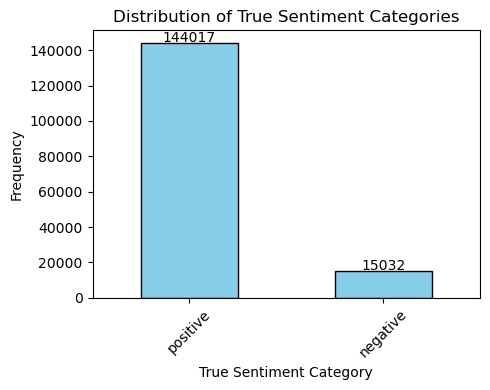

In [29]:
# check distribution of sentiments
value_counts = df_no_3['true_sentiment'].value_counts()

fig, ax = plt.subplots(figsize=(5, 4))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)
ax.set_title('Distribution of True Sentiment Categories')
ax.set_xlabel('True Sentiment Category')
ax.set_ylabel('Frequency')
plt.xticks(rotation=45) 

# Add count numbers on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 4), textcoords='offset points')

plt.tight_layout()  

# Display the plot
plt.show()


In [30]:
# undersampling 

# Separate majority and minority classes
df_majority = df_no_3[df_no_3['true_sentiment'] == 'positive']
df_minority = df_no_3[df_no_3['true_sentiment'] == 'negative']

# Undersample the majority class
df_majority_undersampled = df_majority.sample(n=len(df_minority), random_state=42)
df_undersampled = pd.concat([df_majority_undersampled, df_minority], axis=0)
df_undersampled = df_undersampled.sample(frac=1, random_state=2023).reset_index(drop=True)


## Model Improvement 

multiple training explorations with different: 
- training data & labels
- preprocesser
- word embedding
- features

### exploration on different training data and labels

#### train with only positive and negative labels 
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: no dup data, still imbalanced
- features: only 'review_text'
- preprocessor: lowercase
- vectorizer: count

In [31]:
# training data using df_no_3
preprocessors = ['lowercase']
nb_classifier = NaiveBayesClassifier(data=df_no_3, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = nb_classifier.train(vectorizer_type='count', use_additional_features=False)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [32]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.94623
Test Accuracy: 0.94285


In [33]:
# set column labels
labels = sorted(nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.94623
precision: 0.95119
recall: 0.94623
f1: 0.94817
f2: 0.94722

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,7325,1761
True positive,3370,82973


In [34]:
# get train evaluation for test set
print("\nTest:")
nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94285
precision: 0.94657
recall: 0.94285
f1: 0.94441
f2: 0.94359

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,4518,1428
True positive,2208,55466


In [35]:
new_entry = {
    'Name': 'No neutral Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews'
}

new_entry


{'Name': 'No neutral Model',
 'Train Accuracy': 0.9462322773999517,
 'Train Precision': 0.9511946828308208,
 'Train Recall': 0.9462322773999517,
 'Train F1': 0.9481661829847488,
 'Train F2': 0.9472206119215117,
 'Train Confusion Matrix': [[7325, 1761], [3370, 82973]],
 'Test Accuracy': 0.9428481609556744,
 'Test Precision': 0.9465652252757726,
 'Test Recall': 0.9428481609556744,
 'Test F1': 0.9444125452839968,
 'Test F2': 0.9435892365393347,
 'Test Confusion Matrix': [[4518, 1428], [2208, 55466]],
 'Preprocesser': ['lowercase'],
 'Vectorizer': 'count',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text',
 'Target': 'positive, neutral',
 'remarks': 'no duplicates reviews, only positive and negative reviews'}

In [36]:
results_list.append(new_entry)
results_list

[{'Name': 'Baseline Model',
  'Train Accuracy': 0.8726330027051398,
  'Train Precision': 0.8848691353143678,
  'Train Recall': 0.8726330027051398,
  'Train F1': 0.8779655023510915,
  'Train F2': 0.8750530815889245,
  'Train Confusion Matrix': [[7653, 1299, 1535],
   [1562, 4470, 2766],
   [2655, 4873, 88523]],
  'Test Accuracy': 0.8633650232146806,
  'Test Precision': 0.8744765243432968,
  'Test Recall': 0.8633650232146806,
  'Test F1': 0.8683897893617993,
  'Test F2': 0.8655646758307657,
  'Test Confusion Matrix': [[4646, 1017, 1148],
   [1263, 2468, 2059],
   [1741, 3278, 59271]],
  'Preprocesser': ['lowercase'],
  'Vectorizer': 'count',
  'Classifier': 'Naive Bayes',
  'Feature': 'review_text',
  'Target': 'positive, negative, neutral',
  'remarks': 'baseline model'},
 {'Name': 'No neutral Model',
  'Train Accuracy': 0.9462322773999517,
  'Train Precision': 0.9511946828308208,
  'Train Recall': 0.9462322773999517,
  'Train F1': 0.9481661829847488,
  'Train F2': 0.9472206119215117,
 

#### train with undersampling

#### train with undersampling dataset
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: no dup data, undersampled to reach balanced data
- features: only 'review_text'
- preprocessor: lowercase
- vectorizer: count

In [37]:
# training data using df_undersampled
preprocessors = ['lowercase']
nb_classifier = NaiveBayesClassifier(data=df_undersampled, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = nb_classifier.train(vectorizer_type='count', use_additional_features=False)

In [38]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.92688
Test Accuracy: 0.91385


In [39]:
# set column labels
labels = sorted(nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.92688
precision: 0.92722
recall: 0.92688
f1: 0.92687
f2: 0.92694

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,8460,533
True positive,786,8259


In [40]:
# get train evaluation for test set
print("\nTest:")
nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.91385
precision: 0.91412
recall: 0.91385
f1: 0.91383
f2: 0.91391

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,5599,440
True positive,596,5391


In [41]:
new_entry = {
    'Name': 'Undersampled Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, balanced data with undersampling'
}

new_entry


{'Name': 'Undersampled Model',
 'Train Accuracy': 0.9268765938574122,
 'Train Precision': 0.9272186367296246,
 'Train Recall': 0.9268765938574122,
 'Train F1': 0.926865163754098,
 'Train F2': 0.9269449822421036,
 'Train Confusion Matrix': [[8460, 533], [786, 8259]],
 'Test Accuracy': 0.9138533178114087,
 'Test Precision': 0.9141224568997468,
 'Test Recall': 0.9138533178114087,
 'Test F1': 0.91383398415361,
 'Test F2': 0.9139071329497922,
 'Test Confusion Matrix': [[5599, 440], [596, 5391]],
 'Preprocesser': ['lowercase'],
 'Vectorizer': 'count',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text',
 'Target': 'positive, neutral',
 'remarks': 'no duplicates reviews, only positive and negative reviews, balanced data with undersampling'}

In [42]:
results_list.append(new_entry)
results_list

[{'Name': 'Baseline Model',
  'Train Accuracy': 0.8726330027051398,
  'Train Precision': 0.8848691353143678,
  'Train Recall': 0.8726330027051398,
  'Train F1': 0.8779655023510915,
  'Train F2': 0.8750530815889245,
  'Train Confusion Matrix': [[7653, 1299, 1535],
   [1562, 4470, 2766],
   [2655, 4873, 88523]],
  'Test Accuracy': 0.8633650232146806,
  'Test Precision': 0.8744765243432968,
  'Test Recall': 0.8633650232146806,
  'Test F1': 0.8683897893617993,
  'Test F2': 0.8655646758307657,
  'Test Confusion Matrix': [[4646, 1017, 1148],
   [1263, 2468, 2059],
   [1741, 3278, 59271]],
  'Preprocesser': ['lowercase'],
  'Vectorizer': 'count',
  'Classifier': 'Naive Bayes',
  'Feature': 'review_text',
  'Target': 'positive, negative, neutral',
  'remarks': 'baseline model'},
 {'Name': 'No neutral Model',
  'Train Accuracy': 0.9462322773999517,
  'Train Precision': 0.9511946828308208,
  'Train Recall': 0.9462322773999517,
  'Train F1': 0.9481661829847488,
  'Train F2': 0.9472206119215117,
 

#### Conclusion

1. Normal Model:
- performs better on both training and testing data compared to the undersampling model
- difference between the training and testing metrics is less pronounced, suggesting that the model is generalizing better to unseen data than the undersampling model.

2. Undersampling Model:
- slightly lower metrics than the normal model
- difference between train and test metrics is higher, this suggests a bit more overfitting than undersampling model

3. normal model with only postive and negtive labels with no duplicates date is the best model

### exploration with different stopwords preprocessor

#### train with stopword and lowercase preprocessor
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, stopword
- vectorizer: count

In [43]:
# training data using df_no_3
preprocessors = ['lowercase','stopword']
nb_classifier = NaiveBayesClassifier(data=df_no_3, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = nb_classifier.train(vectorizer_type='count', use_additional_features=False)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [44]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.94691
Test Accuracy: 0.94367


In [45]:
# set column labels
labels = sorted(nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.94691
precision: 0.94855
recall: 0.94691
f1: 0.94765
f2: 0.94724

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,6846,2240
True positive,2826,83517


In [46]:
# get train evaluation for test set
print("\nTest:")
nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94367
precision: 0.94402
recall: 0.94367
f1: 0.94384
f2: 0.94374

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,4195,1751
True positive,1833,55841


In [47]:
new_entry = {
    'Name': 'Normal Stopword Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews'
}

new_entry


{'Name': 'Normal Stopword Model',
 'Train Accuracy': 0.9469134120655147,
 'Train Precision': 0.9485472246108236,
 'Train Recall': 0.9469134120655147,
 'Train F1': 0.9476522448434119,
 'Train F2': 0.9472397241572248,
 'Train Confusion Matrix': [[6846, 2240], [2826, 83517]],
 'Test Accuracy': 0.9436655139893115,
 'Test Precision': 0.9440182576082424,
 'Test Recall': 0.9436655139893115,
 'Test F1': 0.9438383699671768,
 'Test F2': 0.9437360416224277,
 'Test Confusion Matrix': [[4195, 1751], [1833, 55841]],
 'Preprocesser': ['lowercase', 'stopword'],
 'Vectorizer': 'count',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text',
 'Target': 'positive, neutral',
 'remarks': 'no duplicates reviews, only positive and negative reviews'}

In [48]:
results_list.append(new_entry)
results_list

[{'Name': 'Baseline Model',
  'Train Accuracy': 0.8726330027051398,
  'Train Precision': 0.8848691353143678,
  'Train Recall': 0.8726330027051398,
  'Train F1': 0.8779655023510915,
  'Train F2': 0.8750530815889245,
  'Train Confusion Matrix': [[7653, 1299, 1535],
   [1562, 4470, 2766],
   [2655, 4873, 88523]],
  'Test Accuracy': 0.8633650232146806,
  'Test Precision': 0.8744765243432968,
  'Test Recall': 0.8633650232146806,
  'Test F1': 0.8683897893617993,
  'Test F2': 0.8655646758307657,
  'Test Confusion Matrix': [[4646, 1017, 1148],
   [1263, 2468, 2059],
   [1741, 3278, 59271]],
  'Preprocesser': ['lowercase'],
  'Vectorizer': 'count',
  'Classifier': 'Naive Bayes',
  'Feature': 'review_text',
  'Target': 'positive, negative, neutral',
  'remarks': 'baseline model'},
 {'Name': 'No neutral Model',
  'Train Accuracy': 0.9462322773999517,
  'Train Precision': 0.9511946828308208,
  'Train Recall': 0.9462322773999517,
  'Train F1': 0.9481661829847488,
  'Train F2': 0.9472206119215117,
 

#### train with custom_stopword and lowercase preprocessor
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, custom_stopword
- vectorizer: count

In [49]:
# training data using df_no_3
preprocessors = ['lowercase','custom_stopword']
nb_classifier = NaiveBayesClassifier(data=df_no_3, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = nb_classifier.train(vectorizer_type='count', use_additional_features=False)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [50]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.94967
Test Accuracy: 0.94638


In [51]:
# set column labels
labels = sorted(nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.94967
precision: 0.95103
recall: 0.94967
f1: 0.95029
f2: 0.94994

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,6942,2144
True positive,2659,83684


In [52]:
# get train evaluation for test set
print("\nTest:")
nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94638
precision: 0.94633
recall: 0.94638
f1: 0.94636
f2: 0.94637

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,4234,1712
True positive,1699,55975


In [53]:
new_entry = {
    'Name': 'Custom Stopword Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'
}

new_entry


{'Name': 'Custom Stopword Model',
 'Train Accuracy': 0.9496693877123307,
 'Train Precision': 0.9510291904372525,
 'Train Recall': 0.9496693877123307,
 'Train F1': 0.9502876503018961,
 'Train F2': 0.9499410370841335,
 'Train Confusion Matrix': [[6942, 2144], [2659, 83684]],
 'Test Accuracy': 0.9463847846589123,
 'Test Precision': 0.9463323336832506,
 'Test Recall': 0.9463847846589123,
 'Test F1': 0.9463584682072997,
 'Test F2': 0.9463742939986453,
 'Test Confusion Matrix': [[4234, 1712], [1699, 55975]],
 'Preprocesser': ['lowercase', 'custom_stopword'],
 'Vectorizer': 'count',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text',
 'Target': 'positive, neutral',
 'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'}

In [54]:
results_list.append(new_entry)
results_list

[{'Name': 'Baseline Model',
  'Train Accuracy': 0.8726330027051398,
  'Train Precision': 0.8848691353143678,
  'Train Recall': 0.8726330027051398,
  'Train F1': 0.8779655023510915,
  'Train F2': 0.8750530815889245,
  'Train Confusion Matrix': [[7653, 1299, 1535],
   [1562, 4470, 2766],
   [2655, 4873, 88523]],
  'Test Accuracy': 0.8633650232146806,
  'Test Precision': 0.8744765243432968,
  'Test Recall': 0.8633650232146806,
  'Test F1': 0.8683897893617993,
  'Test F2': 0.8655646758307657,
  'Test Confusion Matrix': [[4646, 1017, 1148],
   [1263, 2468, 2059],
   [1741, 3278, 59271]],
  'Preprocesser': ['lowercase'],
  'Vectorizer': 'count',
  'Classifier': 'Naive Bayes',
  'Feature': 'review_text',
  'Target': 'positive, negative, neutral',
  'remarks': 'baseline model'},
 {'Name': 'No neutral Model',
  'Train Accuracy': 0.9462322773999517,
  'Train Precision': 0.9511946828308208,
  'Train Recall': 0.9462322773999517,
  'Train F1': 0.9481661829847488,
  'Train F2': 0.9472206119215117,
 

#### Conclusion

Recall measures the proportion of actual negative reviews that are correctly identified. A high recall means the ability to capture a large proportion of the negative reviews, even if some positive reviews are incorrectly identified as negative. 

F2 Score weights recall higher than precision.

Given in the context of reviews, a negative review might be more concerned to the business, thus recall and F2-score should be the primary metric to look at here.

Comparing different model using different stopword preprocessor
- Model 1 (No stopwords): Train recall: 0.94623, Test recall: 0.94285
- Model 2 (Common English stopwords): Train recall: 0.94691, Test recall: 0.94367
- Model 3 (Custom stopwords): Train recall: 0.94967, Test recall: 0.94638

Model 3 not only has the highest recall but also generally performs the best in terms of accuracy, precision, F1, and F2 scores on both the training and testing datasets. There's also not a significant discrepancy between training and test scores, suggesting that overfitting is not a major concern.

Given the emphasis on maximizing recall alongside comprehensive performance metrics, Model 3 with Custom stopwords should be selected



### exploration with different text form preprocessor

#### train with lemmatizer
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, custom_stopword, lemmatizer
- vectorizer: count

In [55]:
# training data using df_no_3
preprocessors = ['lowercase','custom_stopword','lemmatizer']
nb_classifier = NaiveBayesClassifier(data=df_no_3, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = nb_classifier.train(vectorizer_type='count', use_additional_features=False)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [56]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.94849
Test Accuracy: 0.94455


In [57]:
# set column labels
labels = sorted(nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.94849
precision: 0.94944
recall: 0.94849
f1: 0.94893
f2: 0.94868

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,6809,2277
True positive,2639,83704


In [58]:
# get train evaluation for test set
print("\nTest:")
nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94455
precision: 0.94421
recall: 0.94455
f1: 0.94437
f2: 0.94448

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,4141,1805
True positive,1723,55951


In [59]:
new_entry = {
    'Name': 'Lemmatizer Stopword Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords, with lemmatization'
}

new_entry


{'Name': 'Lemmatizer Stopword Model',
 'Train Accuracy': 0.9484852612937367,
 'Train Precision': 0.9494443675622162,
 'Train Recall': 0.9484852612937367,
 'Train F1': 0.9489342374189048,
 'Train F2': 0.9486769274974682,
 'Train Confusion Matrix': [[6809, 2277], [2639, 83704]],
 'Test Accuracy': 0.9445457403332286,
 'Test Precision': 0.9442073072121617,
 'Test Recall': 0.9445457403332286,
 'Test F1': 0.9443729204278222,
 'Test F2': 0.9444780343016217,
 'Test Confusion Matrix': [[4141, 1805], [1723, 55951]],
 'Preprocesser': ['lowercase', 'custom_stopword', 'lemmatizer'],
 'Vectorizer': 'count',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text',
 'Target': 'positive, neutral',
 'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords, with lemmatization'}

In [60]:
results_list.append(new_entry)
results_list

[{'Name': 'Baseline Model',
  'Train Accuracy': 0.8726330027051398,
  'Train Precision': 0.8848691353143678,
  'Train Recall': 0.8726330027051398,
  'Train F1': 0.8779655023510915,
  'Train F2': 0.8750530815889245,
  'Train Confusion Matrix': [[7653, 1299, 1535],
   [1562, 4470, 2766],
   [2655, 4873, 88523]],
  'Test Accuracy': 0.8633650232146806,
  'Test Precision': 0.8744765243432968,
  'Test Recall': 0.8633650232146806,
  'Test F1': 0.8683897893617993,
  'Test F2': 0.8655646758307657,
  'Test Confusion Matrix': [[4646, 1017, 1148],
   [1263, 2468, 2059],
   [1741, 3278, 59271]],
  'Preprocesser': ['lowercase'],
  'Vectorizer': 'count',
  'Classifier': 'Naive Bayes',
  'Feature': 'review_text',
  'Target': 'positive, negative, neutral',
  'remarks': 'baseline model'},
 {'Name': 'No neutral Model',
  'Train Accuracy': 0.9462322773999517,
  'Train Precision': 0.9511946828308208,
  'Train Recall': 0.9462322773999517,
  'Train F1': 0.9481661829847488,
  'Train F2': 0.9472206119215117,
 

#### train with remove_plural preprocessor
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, custom_stopword, remove_plural
- vectorizer: count

In [61]:
# training data using df_no_3
preprocessors = ['lowercase','custom_stopword','remove_plural']
nb_classifier = NaiveBayesClassifier(data=df_no_3, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = nb_classifier.train(vectorizer_type='count', use_additional_features=False)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [62]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.94812
Test Accuracy: 0.94409


In [63]:
# set column labels
labels = sorted(nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.94812
precision: 0.94897
recall: 0.94812
f1: 0.94852
f2: 0.94829

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,6771,2315
True positive,2636,83707


In [64]:
# get train evaluation for test set
print("\nTest:")
nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94409
precision: 0.94380
recall: 0.94409
f1: 0.94394
f2: 0.94403

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,4133,1813
True positive,1744,55930


In [65]:
new_entry = {
    'Name': 'remove plural Stopword Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords, remove_plural'
}

new_entry


{'Name': 'remove plural Stopword Model',
 'Train Accuracy': 0.9481184964738182,
 'Train Precision': 0.9489705534982907,
 'Train Recall': 0.9481184964738182,
 'Train F1': 0.9485204637838291,
 'Train F2': 0.9482887854502027,
 'Train Confusion Matrix': [[6771, 2315], [2636, 83707]],
 'Test Accuracy': 0.9440899088337001,
 'Test Precision': 0.9438021171248402,
 'Test Recall': 0.9440899088337001,
 'Test F1': 0.9439434733160565,
 'Test F2': 0.9440323364518635,
 'Test Confusion Matrix': [[4133, 1813], [1744, 55930]],
 'Preprocesser': ['lowercase', 'custom_stopword', 'remove_plural'],
 'Vectorizer': 'count',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text',
 'Target': 'positive, neutral',
 'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords, remove_plural'}

In [66]:
results_list.append(new_entry)
results_list

[{'Name': 'Baseline Model',
  'Train Accuracy': 0.8726330027051398,
  'Train Precision': 0.8848691353143678,
  'Train Recall': 0.8726330027051398,
  'Train F1': 0.8779655023510915,
  'Train F2': 0.8750530815889245,
  'Train Confusion Matrix': [[7653, 1299, 1535],
   [1562, 4470, 2766],
   [2655, 4873, 88523]],
  'Test Accuracy': 0.8633650232146806,
  'Test Precision': 0.8744765243432968,
  'Test Recall': 0.8633650232146806,
  'Test F1': 0.8683897893617993,
  'Test F2': 0.8655646758307657,
  'Test Confusion Matrix': [[4646, 1017, 1148],
   [1263, 2468, 2059],
   [1741, 3278, 59271]],
  'Preprocesser': ['lowercase'],
  'Vectorizer': 'count',
  'Classifier': 'Naive Bayes',
  'Feature': 'review_text',
  'Target': 'positive, negative, neutral',
  'remarks': 'baseline model'},
 {'Name': 'No neutral Model',
  'Train Accuracy': 0.9462322773999517,
  'Train Precision': 0.9511946828308208,
  'Train Recall': 0.9462322773999517,
  'Train F1': 0.9481661829847488,
  'Train F2': 0.9472206119215117,
 

#### conclusion

Although Model 2 (with lemmatization) slightly outperforms the others in terms of recall and the F2 score, the difference is marginal. 

The consistent performance of all three models between training and testing indicates that overfitting is not an evident concern. 

Given that lemmatization requires a longer processing time, a simple base model might suffice


### exploration with different vectorization method

#### train with tfidf instead of count
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, custom_stopword
- vectorizer: tfidf

In [67]:
# training data using df_no_3
preprocessors = ['lowercase','custom_stopword']
nb_classifier = NaiveBayesClassifier(data=df_no_3, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = nb_classifier.train(vectorizer_type='tfidf', use_additional_features=False)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [68]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.91516
Test Accuracy: 0.91352


In [69]:
# set column labels
labels = sorted(nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.91516
precision: 0.90954
recall: 0.91516
f1: 0.88608
f2: 0.91403

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,1210,7876
True positive,220,86123


In [70]:
# get train evaluation for test set
print("\nTest:")
nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.91352
precision: 0.91158
recall: 0.91352
f1: 0.87974
f2: 0.91313

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,506,5440
True positive,62,57612


In [71]:
new_entry = {
    'Name': 'TFIDF Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'tfidf',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'
}

new_entry


{'Name': 'TFIDF Model',
 'Train Accuracy': 0.9151620576554297,
 'Train Precision': 0.9095414992744243,
 'Train Recall': 0.9151620576554297,
 'Train F1': 0.88608042548308,
 'Train F2': 0.9140323956343144,
 'Train Confusion Matrix': [[1210, 7876], [220, 86123]],
 'Test Accuracy': 0.9135177617101541,
 'Test Precision': 0.9115839018207799,
 'Test Recall': 0.9135177617101541,
 'Test F1': 0.879743886491914,
 'Test F2': 0.9131303336034489,
 'Test Confusion Matrix': [[506, 5440], [62, 57612]],
 'Preprocesser': ['lowercase', 'custom_stopword'],
 'Vectorizer': 'tfidf',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text',
 'Target': 'positive, neutral',
 'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'}

In [72]:
results_list.append(new_entry)
results_list

[{'Name': 'Baseline Model',
  'Train Accuracy': 0.8726330027051398,
  'Train Precision': 0.8848691353143678,
  'Train Recall': 0.8726330027051398,
  'Train F1': 0.8779655023510915,
  'Train F2': 0.8750530815889245,
  'Train Confusion Matrix': [[7653, 1299, 1535],
   [1562, 4470, 2766],
   [2655, 4873, 88523]],
  'Test Accuracy': 0.8633650232146806,
  'Test Precision': 0.8744765243432968,
  'Test Recall': 0.8633650232146806,
  'Test F1': 0.8683897893617993,
  'Test F2': 0.8655646758307657,
  'Test Confusion Matrix': [[4646, 1017, 1148],
   [1263, 2468, 2059],
   [1741, 3278, 59271]],
  'Preprocesser': ['lowercase'],
  'Vectorizer': 'count',
  'Classifier': 'Naive Bayes',
  'Feature': 'review_text',
  'Target': 'positive, negative, neutral',
  'remarks': 'baseline model'},
 {'Name': 'No neutral Model',
  'Train Accuracy': 0.9462322773999517,
  'Train Precision': 0.9511946828308208,
  'Train Recall': 0.9462322773999517,
  'Train F1': 0.9481661829847488,
  'Train F2': 0.9472206119215117,
 

BOW(count vector) preforms better than TFIDF. This is uncommon. 
- Nature of Reviews: TF-IDF is designed to reduce the weight of words that appear frequently across all reviews, which might be beneficial if those words don't carry significant sentiment value. However, this can also be a double-edged sword; if certain frequent words do have significant sentiment implications, TF-IDF could inadvertently diminish their importance.
- Product Specificity: Since Sephora reviews will span a multitude of products, certain terms might be crucial to one product but not to another. TF-IDF will amplify these product-specific terms, while Count Vectorization will treat them just like any other term.

### exploration on additional features

#### train with additional features
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: all features 
- preprocessor: lowercase, custom_stopword
- vectorizer: count

In [73]:
df_no_3.columns

Index(['rating', 'is_recommended', 'helpfulness', 'submission_time',
       'review_text', 'review_title', 'length', 'product_name', 'brand_name',
       'price_usd', 'primary_category', 'secondary_category',
       'tertiary_category', 'true_sentiment', 'reviews_processed',
       'prediction'],
      dtype='object')

In [74]:
df_additional_features = df_no_3[['review_text','helpfulness', 'length', 'true_sentiment','price_usd']]

In [75]:
# training data using df_no_3
preprocessors = ['lowercase','custom_stopword']
nb_classifier = NaiveBayesClassifier(data=df_additional_features, text_col='review_text', preprocessors=preprocessors)


In [76]:
train_metrics, test_metrics = nb_classifier.train(vectorizer_type='count', use_additional_features=True)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [77]:
# # get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.94967
Test Accuracy: 0.94638


In [78]:
# # set column labels
labels = sorted(nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.94967
precision: 0.95103
recall: 0.94967
f1: 0.95029
f2: 0.94994

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,6942,2144
True positive,2659,83684


In [79]:
# # get train evaluation for test set
print("\nTest:")
nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94638
precision: 0.94633
recall: 0.94638
f1: 0.94636
f2: 0.94637

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,4234,1712
True positive,1699,55975


In [80]:
new_entry = {
    'Name': 'Additional Feature Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text, helpfulness, length, price_usd',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'
}

new_entry


{'Name': 'Additional Feature Model',
 'Train Accuracy': 0.9496693877123307,
 'Train Precision': 0.9510291904372525,
 'Train Recall': 0.9496693877123307,
 'Train F1': 0.9502876503018961,
 'Train F2': 0.9499410370841335,
 'Train Confusion Matrix': [[6942, 2144], [2659, 83684]],
 'Test Accuracy': 0.9463847846589123,
 'Test Precision': 0.9463323336832506,
 'Test Recall': 0.9463847846589123,
 'Test F1': 0.9463584682072997,
 'Test F2': 0.9463742939986453,
 'Test Confusion Matrix': [[4234, 1712], [1699, 55975]],
 'Preprocesser': ['lowercase', 'custom_stopword'],
 'Vectorizer': 'count',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text, helpfulness, length, price_usd',
 'Target': 'positive, neutral',
 'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'}

In [81]:
results_list.append(new_entry)
results_list

[{'Name': 'Baseline Model',
  'Train Accuracy': 0.8726330027051398,
  'Train Precision': 0.8848691353143678,
  'Train Recall': 0.8726330027051398,
  'Train F1': 0.8779655023510915,
  'Train F2': 0.8750530815889245,
  'Train Confusion Matrix': [[7653, 1299, 1535],
   [1562, 4470, 2766],
   [2655, 4873, 88523]],
  'Test Accuracy': 0.8633650232146806,
  'Test Precision': 0.8744765243432968,
  'Test Recall': 0.8633650232146806,
  'Test F1': 0.8683897893617993,
  'Test F2': 0.8655646758307657,
  'Test Confusion Matrix': [[4646, 1017, 1148],
   [1263, 2468, 2059],
   [1741, 3278, 59271]],
  'Preprocesser': ['lowercase'],
  'Vectorizer': 'count',
  'Classifier': 'Naive Bayes',
  'Feature': 'review_text',
  'Target': 'positive, negative, neutral',
  'remarks': 'baseline model'},
 {'Name': 'No neutral Model',
  'Train Accuracy': 0.9462322773999517,
  'Train Precision': 0.9511946828308208,
  'Train Recall': 0.9462322773999517,
  'Train F1': 0.9481661829847488,
  'Train F2': 0.9472206119215117,
 

## model comparision

In [82]:
data = pd.DataFrame(results_list)
data

,Name,Train Accuracy,Train Precision,Train Recall,Train F1,Train F2,Train Confusion Matrix,Test Accuracy,Test Precision,Test Recall,Test F1,Test F2,Test Confusion Matrix,Preprocesser,Vectorizer,Classifier,Feature,Target,remarks
0,Baseline Model,0.872633,0.884869,0.872633,0.877966,0.875053,"[[7653, 1299, 1535], [1562, 4470, 2766], [2655...",0.863365,0.874477,0.863365,0.868390,0.865565,"[[4646, 1017, 1148], [1263, 2468, 2059], [1741...",[lowercase],count,Naive Bayes,review_text,"positive, negative, neutral",baseline model
1,No neutral Model,0.946232,0.951195,0.946232,0.948166,0.947221,"[[7325, 1761], [3370, 82973]]",0.942848,0.946565,0.942848,0.944413,0.943589,"[[4518, 1428], [2208, 55466]]",[lowercase],count,Naive Bayes,review_text,"positive, neutral","no duplicates reviews, only positive and negat..."
2,Undersampled Model,0.926877,0.927219,0.926877,0.926865,0.926945,"[[8460, 533], [786, 8259]]",0.913853,0.914122,0.913853,0.913834,0.913907,"[[5599, 440], [596, 5391]]",[lowercase],count,Naive Bayes,review_text,"positive, neutral","no duplicates reviews, only positive and negat..."
3,Normal Stopword Model,0.946913,0.948547,0.946913,0.947652,0.947240,"[[6846, 2240], [2826, 83517]]",0.943666,0.944018,0.943666,0.943838,0.943736,"[[4195, 1751], [1833, 55841]]","[lowercase, stopword]",count,Naive Bayes,review_text,"positive, neutral","no duplicates reviews, only positive and negat..."
4,Custom Stopword Model,0.949669,0.951029,0.949669,0.950288,0.949941,"[[6942, 2144], [2659, 83684]]",0.946385,0.946332,0.946385,0.946358,0.946374,"[[4234, 1712], [1699, 55975]]","[lowercase, custom_stopword]",count,Naive Bayes,review_text,"positive, neutral","no duplicates reviews, only positive and negat..."
5,Lemmatizer Stopword Model,0.948485,0.949444,0.948485,0.948934,0.948677,"[[6809, 2277], [2639, 83704]]",0.944546,0.944207,0.944546,0.944373,0.944478,"[[4141, 1805], [1723, 55951]]","[lowercase, custom_stopword, lemmatizer]",count,Naive Bayes,review_text,"positive, neutral","no duplicates reviews, only positive and negat..."
6,remove plural Stopword Model,0.948118,0.948971,0.948118,0.948520,0.948289,"[[6771, 2315], [2636, 83707]]",0.944090,0.943802,0.944090,0.943943,0.944032,"[[4133, 1813], [1744, 55930]]","[lowercase, custom_stopword, remove_plural]",count,Naive Bayes,review_text,"positive, neutral","no duplicates reviews, only positive and negat..."
7,TFIDF Model,0.915162,0.909541,0.915162,0.886080,0.914032,"[[1210, 7876], [220, 86123]]",0.913518,0.911584,0.913518,0.879744,0.913130,"[[506, 5440], [62, 57612]]","[lowercase, custom_stopword]",tfidf,Naive Bayes,review_text,"positive, neutral","no duplicates reviews, only positive and negat..."
8,Additional Feature Model,0.949669,0.951029,0.949669,0.950288,0.949941,"[[6942, 2144], [2659, 83684]]",0.946385,0.946332,0.946385,0.946358,0.946374,"[[4234, 1712], [1699, 55975]]","[lowercase, custom_stopword]",count,Naive Bayes,"review_text, helpfulness, length, price_usd","positive, neutral","no duplicates reviews, only positive and negat..."


In [83]:
# # plot individual confusion matrices
# from naive_bayes_utils import NaiveBayesVisualization
# visualizer = NaiveBayesVisualization(nb_classifier)
# X_test = latest_review['reviews_processed'].tolist()  # Assuming you have transformed the reviews accordingly
# y_true = latest_review['true_sentiment'].tolist()
# visualizer.plot_individual_confusion_matrices(X_test, y_true)

## Advanced Analysis